In [ ]:
# ----------------------------------------------------------------------------
#
# TITLE - triaxial_potential_DF.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Calculate the actions around the strange features in the triaxial DF
'''

__author__ = "James Lane"

In [ ]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb
import importlib

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm
# import aplpy

## Astropy
from astropy import units as apu

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.df

In [3]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work
- Go in depth into the functions that calculate the radial action

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Keywords and Functions

In [4]:
### Keywords

# Halo evolution
t_evolve = 10 # Gyr
tform = -9 # Gyr ago
tsteady = 8 # Gyr after tform

# The times over which each orbit will be integrated
times = -np.array([0,t_evolve]) * apu.Gyr

In [5]:
### Function definitions

def gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi):
    
    # Generate the velocity range
    vR_range = np.arange( vR_low, vR_hi, dvR )
    vT_range = np.arange( vT_low, vT_hi, dvT )

    # Generate the array of distribution function values
    dfp = np.zeros((len(vR_range),len(vT_range)))
    df0 = np.zeros((len(vR_range),len(vT_range)))

    # Output information
    print( str(len(vR_range)*len(vT_range))+' independent velocities' )
    print( str(len(vR_range))+' Between vR=['+str(round(np.amin(vR_range)))+','+str(round(np.amax(vR_range)))+']')
    print( str(len(vR_range))+' Between vR=['+str(round(np.amin(vT_range)))+','+str(round(np.amax(vT_range)))+']')
    print('\n')
    print(vR_range)
    print(vT_range)
    print('\n')
    
    return df0, dfp, vR_range, vT_range
#def

def eval_df(vxvv, times, pot, vR_range, vT_range, df0, dfp):
    
    vxvv_use = copy.deepcopy(vxvv)
    for j in tqdm_nb( range( len(vR_range) ) ):
        for k in range( len(vT_range) ):

            # Make the orbit
            vxvv_use[1] = vR_range[j]*apu.km/apu.s
            vxvv_use[2] = vT_range[k]*apu.km/apu.s
            o = orbit.Orbit(vxvv=vxvv_use)

            # Evaluate the unperturbed distribution function if this is the first run-through    
            df0[j,k] = qdf(o)

            # Now evaluate the perturbed distribution function
            o.integrate(times, pot)
            dfp[j,k] = qdf( o(times[-1]) )
        ###k
    ###j
    
    return df0, dfp
#def

def eval_act(vxvv, times, tripot_grow, qdf_aA, vR_range, vT_range, act0, actp, return_kin=False):
    
    if return_kin:
        end_kin = np.zeros((3,len(vR_range),len(vT_range)))
    ##fi
    
    vxvv_use = copy.deepcopy(vxvv)
    for j in tqdm_nb( range( len(vR_range) ) ):
        for k in range( len(vT_range) ):

            # Make the orbit
            vxvv_use[1] = vR_range[j]*apu.km/apu.s
            vxvv_use[2] = vT_range[k]*apu.km/apu.s
            o = orbit.Orbit(vxvv=vxvv_use)

            # Get the actions, angles and frequencies for the unperturbed orbit
            act0[0,j,k],act0[1,j,k],act0[2,j,k] = qdf_aA(o)

            # Integrate the orbit and evaluate 
            o.integrate(times, tripot_grow)
            actp[0,j,k],actp[1,j,k],actp[2,j,k] = qdf_aA( o(times[-1]) )
            
            if return_kin:
                end_kin[0,j,k] = o.R(times[-1]).value
                end_kin[1,j,k] = o.vR(times[-1]).value
                end_kin[2,j,k] = o.vT(times[-1]).value
            ##fi
        ###k
    ###j
    
    if return_kin:
        return act0, actp, end_kin
    else:
        return act0, actp
    ##ie
#def

def hist_df(df0, dfp, vR_low, vR_hi, vT_low, vT_hi, log=False):
    
    ## Make the original distribution function
    img_arr1 = np.rot90( df0/np.max(df0) )
    if log:
        img1 = ax1.imshow(np.log10(img_arr1), interpolation='nearest',
                            extent=[vR_low, vR_hi, vT_low, vT_hi],
                            cmap='viridis', vmax=0, vmin=-3)
        cbar1 = plt.colorbar(img1, ax=ax1)
        cbar1.set_label(r'$\log [f/f_{max}]$', fontsize=16)
    else:
        img1 = ax1.imshow(img_arr1, interpolation='nearest',
                            extent=[vR_low, vR_hi, vT_low, vT_hi],
                            cmap='viridis', vmax=1, vmin=0)
        cbar1 = plt.colorbar(img1, ax=ax1)
        cbar1.set_label(r'$f/f_{max}$', fontsize=16)
    ##ie

    # Decorate
    ax1.set_xlabel(r'$V_{R}$ [km/s]', fontsize=14)
    ax1.set_ylabel(r'$V_{\phi}$ [km/s]', fontsize=14)
    ax1.set_title('MWPotential2014')


    ## Make the triaxial distribution function
    img_arr2 = np.rot90( dfp/np.max(dfp) )
    
    if log:
        img2 = ax2.imshow(np.log10(img_arr2), interpolation='nearest',
                            extent=[vR_low, vR_hi, vT_low, vT_hi],
                            cmap='viridis', vmax=0, vmin=-3)
        cbar2 = plt.colorbar(img2, ax=ax2)
        cbar2.set_label(r'$\log [f/f_{max}]$', fontsize=16)
    else:
        img2 = ax2.imshow(img_arr2, interpolation='nearest',
                            extent=[vR_low, vR_hi, vT_low, vT_hi],
                            cmap='viridis', vmax=1, vmin=0)
        cbar2 = plt.colorbar(img2, ax=ax2)
        cbar2.set_label(r'$f/f_{max}$', fontsize=16)

    # Decorate
    ax2.set_xlabel(r'$V_{R}$ [km/s]', fontsize=14)
    ax2.set_ylabel(r'$V_{\phi}$ [km/s]', fontsize=14)
    ax2.set_title('Triaxial')

    return fig, ax1, ax2, cbar1, cbar2
#def

def hist_act(act, vR_low, vR_hi, vT_low, vT_hi, cbar_labels):
    
    # Loop over the three actions, then over perturbed and unperturbed.
    for i in range(3):
        
        img_arr = np.rot90( act[i] )
        img = axs[i].imshow(img_arr, interpolation='nearest',
            extent=[vR_low, vR_hi, vT_low, vT_hi],
            cmap='Blues')
        
        cbar = plt.colorbar(img, ax=axs[i])
        cbar.set_label(cbar_labels[i])
        axs[i].set_ylabel(r'$V_{\phi}$ [km/s]')
        axs[i].set_xlabel(r'$V_{R}$ [km/s]')
        ###j
    ###i
    return fig, axs
#def

## Potential and Distribution Function

In [6]:
### Make MWPotential2014
mwpot = potential.MWPotential2014

### Make the triaxial halo
trihalo = ast1501.potential.make_MWPotential2014_triaxialNFW(halo_b=2.0, halo_phi=0.0, halo_c=1.0)

### Make MWPotential2014 with DSW around the halo and triaxial halo
tripot_grow = ast1501.potential.make_tripot_dsw(trihalo=trihalo, tform=tform, tsteady=tsteady)
potential.turn_physical_off(tripot_grow)

In [7]:
## Make the quasi-isothermal distribution function. See notebook #3 for the velocity scales.

# Velocity dispersions in km/s
sigma_vR = 46/1.5
sigma_vT = 40/1.5
sigma_vZ = 28/1.5

# Action angle coordinates and the DF
qdf_aA= actionAngleAdiabatic(pot=potential.MWPotential2014, c=True)
qdf = df.quasiisothermaldf( hr= 2*apu.kpc,
                            sr= sigma_vR*(apu.km/apu.s),
                            sz= sigma_vZ*(apu.km/apu.s),
                            hsr= 9.8*(apu.kpc),
                            hsz= 7.6*(apu.kpc),
                            pot= potential.MWPotential2014, 
                            aA= qdf_aA)

# Trial 1: Inner halo
$R=16$ kpc, $z$=0

In [63]:
# Set velocity deltas and range
dvT = 10.
dvR = 10.
vR_low = -4*sigma_vR
vR_hi = 4*sigma_vR
vT_low = -4*sigma_vT+210
vT_hi = 4*sigma_vT+210

# Generate the velocity distribution and DF arrays
df0, dfp, vR_range, vT_range = gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi)

# Declare the orbit parameters
vxvv = [16.*apu.kpc, 
        0, # Leave blank, will be set in loop
        0, # Leave blank, will be set in loop
        0.*apu.kpc,
        0.*apu.km/apu.s,
        0.*apu.radian]

# Evaluate the DF
df0, dfp = eval_df(vxvv, times, tripot_grow, vR_range, vT_range, df0, dfp  )

550 independent velocities
25 Between vR=[-123.0,117.0]
25 Between vR=[103.0,313.0]


[-122.66666667 -112.66666667 -102.66666667  -92.66666667  -82.66666667
  -72.66666667  -62.66666667  -52.66666667  -42.66666667  -32.66666667
  -22.66666667  -12.66666667   -2.66666667    7.33333333   17.33333333
   27.33333333   37.33333333   47.33333333   57.33333333   67.33333333
   77.33333333   87.33333333   97.33333333  107.33333333  117.33333333]
[103.33333333 113.33333333 123.33333333 133.33333333 143.33333333
 153.33333333 163.33333333 173.33333333 183.33333333 193.33333333
 203.33333333 213.33333333 223.33333333 233.33333333 243.33333333
 253.33333333 263.33333333 273.33333333 283.33333333 293.33333333
 303.33333333 313.33333333]




A Jupyter Widget


All done
31.7 s for auto evaluator


In [88]:
importlib.reload(ast1501.df)

# Do the auto evaluator
R_z_phi = [16,0,0]

dfp_auto = np.zeros_like(dfp)
df0_auto = np.zeros_like(df0)

t1 = time.time()
dfp_auto = ast1501.df.evaluate_df_adaptive_vrvt(R_z_phi, times, tripot_grow, qdf, vR_range, vT_range, 
                                                dfp_auto, threshold=0.0001)
t2 = time.time()
print(str(round(t2-t1,1))+' s for auto evaluator perturbed')

t1 = time.time()
df0_auto = ast1501.df.evaluate_df_adaptive_vrvt(R_z_phi, times, tripot_grow, qdf, vR_range, vT_range, df0_auto, 
                                                compute_unperturbed=True, threshold=0.001)
t2 = time.time()
print(str(round(t2-t1,1))+' s for auto evaluator perturbed')

All done
40.2 s for auto evaluator perturbed
All done
0.3 s for auto evaluator perturbed


/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10



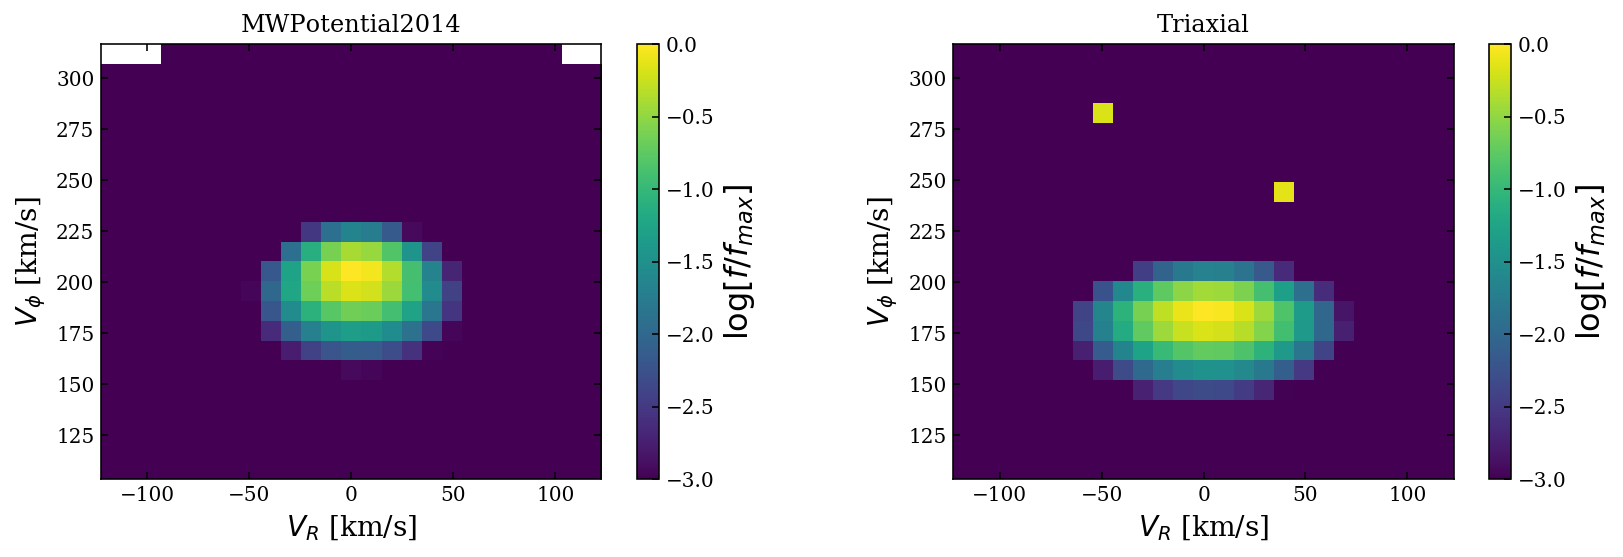

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log10



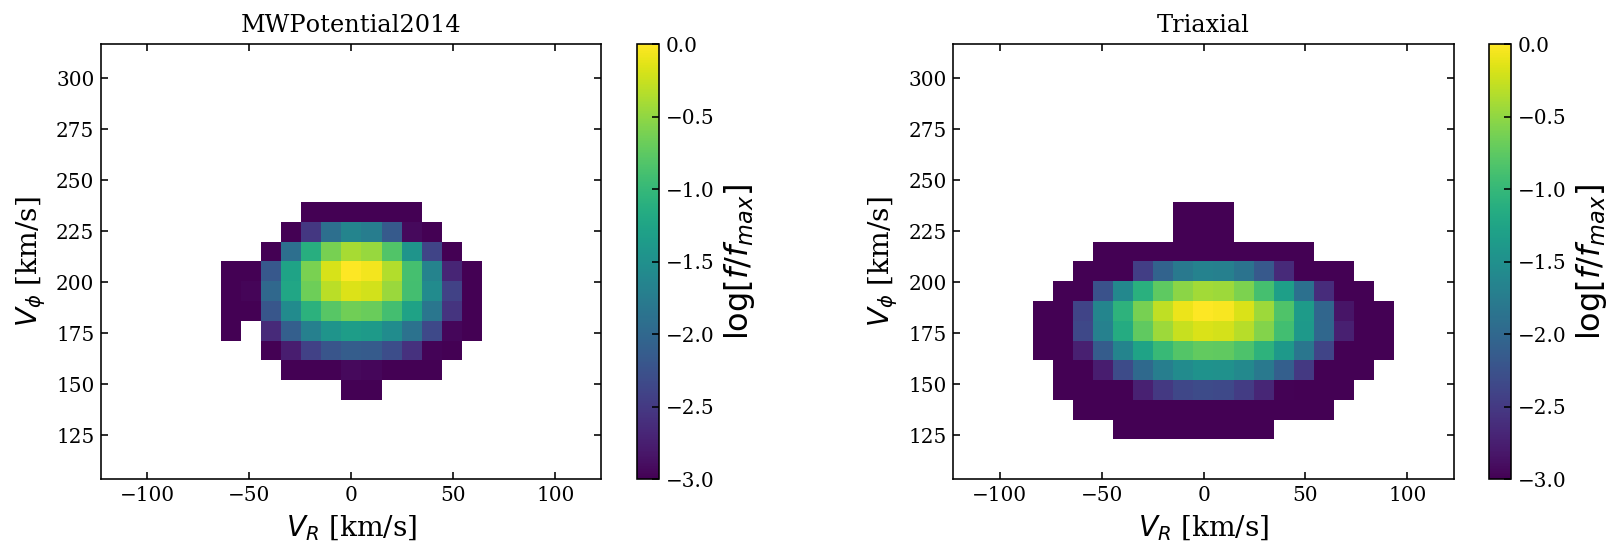

In [89]:
# Make the figure
fig = plt.figure( figsize=(14,4) )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot
fig, ax1, ax2, cbar1, cbar2 = hist_df(df0, dfp, vR_low, vR_hi, vT_low, vT_hi, log=True)
# ax1.grid(color='w', linestyle='-', linewidth=1)
# ax2.grid(color='w', linestyle='-', linewidth=1)
plt.show()
plt.close('all')

# Make the figure
fig = plt.figure( figsize=(14,4) )
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Plot
fig, ax1, ax2, cbar1, cbar2 = hist_df(df0_auto, dfp_auto, vR_low, vR_hi, vT_low, vT_hi, log=True)
# ax1.grid(color='w', linestyle='-', linewidth=1)
# ax2.grid(color='w', linestyle='-', linewidth=1)
plt.show()
plt.close('all')

# No output
pass;

In [90]:
importlib.reload(ast1501.df)

moments0 = ast1501.df.calculate_df_vmoments(df0, vR_range, vT_range, dvR, dvT)
momentsp = ast1501.df.calculate_df_vmoments(dfp, vR_range, vT_range, dvR, dvT)

moments0_auto = ast1501.df.calculate_df_vmoments(df0_auto, vR_range, vT_range, dvR, dvT)
momentsp_auto = ast1501.df.calculate_df_vmoments(dfp_auto, vR_range, vT_range, dvR, dvT)

print(moments0)
print(moments0_auto)
print('\n')
print(momentsp)
print(momentsp_auto)

[382107.49534554663, -5.3791631814799354e-11, 198.87925544185663, 14.114777691805312, 10.085038510443699]
[382020.8586557509, 0.003623066771314026, 198.88864344628476, 14.100620344696031, 10.062963823889916]


[563648.4891849399, -0.612818540151444, 188.85961359999143, 23.72610800786477, 28.295416974511802]
[501151.3779853511, 0.027679654199313612, 179.68079634173864, 19.42481711331217, 9.51574025802697]
